# HNRE

## 0. 预备

In [29]:
import datetime
import json
import os
import pickle
import sys
import time
import torch
import math

WORK_HOME="D:\PycharmProjects\HNRE-Pytorch"
os.chdir(WORK_HOME)
sys.path.append("./")
sys.path.append("./plot")


from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import argparse
import matplotlib
from matplotlib import pyplot as plt
from pylab import *

# from model import network

from torch import autograd, optim
# FLAGS = tf.app.flags.FLAGS
# FLAGS = tf.compat.v1.app.flags.FLAGS
import sys

import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


In [3]:
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Quadro P3000'

In [4]:
config = json.loads(open("./data/config",'r').read())
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(DEVICE)
torch.cuda.current_device()

0

In [5]:
parser = argparse.ArgumentParser()

parser.add_argument('--shot', default=5, type=int, 
        help='Number of seeds')
parser.add_argument('--eval_iter', default=1000, type=int, 
        help='Eval iteration')

# snowball hyperparameter
parser.add_argument("--phase1_add_num", help="number of instances added in phase 1", type=int, default=5)
parser.add_argument("--phase2_add_num", help="number of instances added in phase 2", type=int, default=5)
parser.add_argument("--phase1_siamese_th", help="threshold of relation siamese network in phase 1", type=float, default=0.5)
parser.add_argument("--phase2_siamese_th", help="threshold of relation siamese network in phase 2", type=float, default=0.5)
parser.add_argument("--phase2_cl_th", help="threshold of relation classifier in phase 2", type=float, default=0.9)

parser.add_argument("--snowball_max_iter", help="number of iterations of snowball", type=int, default=5)

# fine-tune hyperparameter
parser.add_argument("--finetune_epoch", help="num of epochs when finetune", type=int, default=50)
parser.add_argument("--finetune_batch_size", help="batch size when finetune", type=int, default=10)
parser.add_argument("--finetune_lr", help="learning rate when finetune", type=float, default=0.05)
parser.add_argument("--finetune_wd", help="weight decay rate when finetune", type=float, default=1e-5)
parser.add_argument("--finetune_weight", help="loss weight of negative samples", type=float, default=0.2)

parser.add_argument('--model', help='neural models to encode sentences',type=str, default= 'cnn')
parser.add_argument('--use_baseline', help='baseline or hier', type=bool, default= False)
parser.add_argument('--gpu', help='gpu to use', type=int, default= '0')
parser.add_argument('--allow_growth', help='memory growth', type=bool, default= False )
parser.add_argument('--data_path', help= 'path to load data', type=str, default= './data/')
parser.add_argument('--model_dir', help='path to store model', type=str, default= './outputs/ckpt/')
parser.add_argument('--summary_dir',help='path to store summary_dir',type=str, default= './outputs/summary')
parser.add_argument('--batch_size', help='entity numbers used each training time', type=int, default= 160)
# training
parser.add_argument('--max_epoch', help='maximum of training epochs', type=int,default= 40)
parser.add_argument('--save_epoch', help='frequency of training epochs', type=int,default=2 )
parser.add_argument('--restore_epoch',help='epoch to continue training',type=int, default=0 )
parser.add_argument('--learning_rate', help='learning rate', type=float, default=0.2 )
parser.add_argument('--weight_decay', help='weight_decay', type=float,default=0.00001 )
parser.add_argument('--keep_prob', help='dropout rate', type=float, default=0.5 )

# test_settings
parser.add_argument('--test_single', help = 'only test one checkpoint', type = bool, default = True)
parser.add_argument('--test_start_ckpt', help = 'first epoch to test', type = int, default = 1)
parser.add_argument('--test_end_ckpt', help = 'last epoch to test', type = int, default = 30)
parser.add_argument('--test_sleep', help = 'time units to sleep ', type = float, default = 10)
parser.add_argument('--test_use_step', help = 'test step instead of epoch', type = bool, default = bool)
parser.add_argument('--test_start_step', help = 'first step to test', type = int, default = 0*1832)
parser.add_argument('--test_end_step', help = 'last step to test', type = int , default = 30*1832)
parser.add_argument('--test_step', help = 'step to add per test', type = int, default = 1832)


# parameters
parser.add_argument('--word_size', help= 'maximum of relations', type=int,default= config['word_size'])
parser.add_argument('--hidden_size', help = 'hidden feature size',type=int, default= 230 )
parser.add_argument('--pos_size', help='position embedding size',type=int, default=5)
# statistics
parser.add_argument('--max_length', help= 'maximum of number of words in one sentence',type=int, default=config['fixlen'])
parser.add_argument('--pos_num', help='number of position embedding vectors', type=int,default= config['maxlen'] * 2 + 1)
parser.add_argument('--num_classes', help='maximum of relations',type=int, default= len(config['relation2id']))
parser.add_argument('--vocabulary_size', help='maximum of relations',type=int, default= len(config['word2id']))

args = parser.parse_args(args = [])

## 1. Load Data

In [14]:
export_path = args.data_path
init_file = './data/initial_vectors/' + ('init_vec_pcnn' if args.model[:4].lower() == 'pcnn' and not args.use_baseline else 'init_vec')
max_length = config['maxlen']
export_path

'./data/'

In [15]:
instance_triple = np.load(export_path + 'train_instance_triple.npy') 
instance_scope = np.load(export_path + 'train_instance_scope.npy')
train_len = np.load(export_path + 'train_len.npy')
train_label = np.load(export_path + 'train_label.npy')
train_word = np.load(export_path + 'train_word.npy')
train_pos1 = np.load(export_path + 'train_pos1.npy')
train_pos2 = np.load(export_path + 'train_pos2.npy')
train_mask = np.load(export_path + 'train_mask.npy')

In [16]:
instance_scope_Tensor = torch.LongTensor(np.load(export_path + 'train_instance_scope.npy')).to(DEVICE)
train_len_Tensor = torch.LongTensor(np.load(export_path + 'train_len.npy')).to(DEVICE)
train_label_Tensor = torch.LongTensor(np.load(export_path + 'train_label.npy')).to(DEVICE)
train_word_Tensor = torch.LongTensor(train_word).to(DEVICE)
train_pos1_Tensor = torch.LongTensor(train_pos1).to(DEVICE)
train_pos2_Tensor = torch.LongTensor(train_pos2).to(DEVICE)
train_mask_Tensor = torch.LongTensor(train_mask).to(DEVICE)

In [17]:
instance_scope_Tensor = torch.LongTensor(np.load(export_path + 'train_instance_scope.npy')).to(DEVICE)
train_len_Tensor = torch.LongTensor(np.load(export_path + 'train_len.npy')).to(DEVICE)
train_label_Tensor = torch.LongTensor(np.load(export_path + 'train_label.npy')).to(DEVICE)
train_word_Tensor = torch.LongTensor(train_word).to(DEVICE)
train_pos1_Tensor = torch.LongTensor(train_pos1).to(DEVICE)
train_pos2_Tensor = torch.LongTensor(train_pos2).to(DEVICE)
train_mask_Tensor = torch.LongTensor(train_mask).to(DEVICE)

In [18]:
init_vec = pickle.load(open(init_file, 'rb'))
init_vec.keys()

dict_keys(['relation_levels', 'wordvec'])

In [19]:
relation_levels_Tensor = torch.LongTensor(init_vec['relation_levels'])
relation_levels_Tensor.shape[0]

53

In [20]:
relation_levels_pd = pd.DataFrame(init_vec['relation_levels'], columns = ['p_index', 'index'])
relation_levels_pd.iloc[:, 0].value_counts()

1    19
5    15
3    10
4     3
7     2
0     1
2     1
6     1
8     1
Name: p_index, dtype: int64

In [21]:
relation_level_layer = (1 + np.max(init_vec['relation_levels'], 0)).astype(np.int32)
relation_level_layer

array([ 9, 53])

## 2. Build Networks

In [22]:
word_size = args.word_size
vocab_size = args.vocabulary_size - 2
print(word_size , vocab_size, args.pos_num)

50 114042 201


In [23]:
class MyEmbedder(nn.Module):
    def __init__(self, word_vec_mat, max_length, pos_dim, word_embedding_dim=50, pos_embedding_dim=5):
        nn.Module.__init__(self)

        self.max_length = max_length
        self.pos_dim = pos_dim
        self.word_embedding_dim = word_embedding_dim
        self.pos_embedding_dim = pos_embedding_dim
        
        # Word embedding
        unk = torch.randn(1, word_embedding_dim) / math.sqrt(word_embedding_dim)
        blk = torch.zeros(1, word_embedding_dim)
        word_vec_mat = torch.from_numpy(word_vec_mat)
        self.word_embedding = nn.Embedding(word_vec_mat.shape[0] + 2, self.word_embedding_dim, padding_idx=word_vec_mat.shape[0] + 1)
        self.word_embedding.weight.data.copy_(torch.cat((word_vec_mat, unk, blk), 0))

        # Position Embedding
        blk_pos = torch.zeros(1, pos_embedding_dim)
        self.pos1_embedding = nn.Embedding(pos_dim + 1, pos_embedding_dim, padding_idx= pos_dim)
        self.pos2_embedding = nn.Embedding(pos_dim + 1, pos_embedding_dim, padding_idx= pos_dim)
#         self.pos1_embedding.weight.data.copy_(torch.cat((pos1_embedding,  blk_pos), 0))
#         self.pos2_embedding.weight.data.copy_(torch.cat((pos2_embedding, blk_pos), 0))

    def forward(self, inputs):
        word = inputs['word']
        pos1 = inputs['pos1']
        pos2 = inputs['pos2']
        
        x = torch.cat([self.word_embedding(word), 
                            self.pos1_embedding(pos1), 
                            self.pos2_embedding(pos2)], 2)
        return x

In [24]:
class MyEncoder(nn.Module):
    def __init__(self, max_length, word_embedding_dim=50, pos_embedding_dim=5, hidden_size=230):
        nn.Module.__init__(self)

        self.max_length = max_length
        self.hidden_size = hidden_size
        self.embedding_dim = word_embedding_dim + pos_embedding_dim * 2
        self.conv = nn.Conv1d(self.embedding_dim, self.hidden_size, 3, padding=1)
        self.pool = nn.MaxPool1d(max_length)

        # For PCNN
        self.mask_embedding = nn.Embedding(4, 3)
        self.mask_embedding.weight.data.copy_(torch.FloatTensor([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0]]))
        self.mask_embedding.weight.requires_grad = False
        self._minus = -100

    def forward(self, inputs):
        return self.cnn(inputs)

    def cnn(self, inputs):
        x = self.conv(inputs.transpose(1, 2))
        x = F.relu(x)
        x = self.pool(x)
        return x.squeeze(2) # n x hidden_size

    def pcnn(self, inputs, mask):
        x = self.conv(inputs.transpose(1, 2)) # n x hidden x length
        mask = 1 - self.mask_embedding(mask).transpose(1, 2) # n x 3 x length
        pool1 = self.pool(F.relu(x + self._minus * mask[:, 0:1, :]))
        pool2 = self.pool(F.relu(x + self._minus * mask[:, 1:2, :]))
        pool3 = self.pool(F.relu(x + self._minus * mask[:, 2:3, :]))
        x = torch.cat([pool1, pool2, pool3], 1)
        x = x.squeeze(2) # n x (hidden_size * 3) 

In [25]:
class MyCNNSentenceEncoder(nn.Module):

    def __init__(self, word_vec_mat, max_length, pos_dim, word_embedding_dim=50, pos_embedding_dim=5, hidden_size=230):
        nn.Module.__init__(self)
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.pos_dim = pos_dim
        self.embedding = MyEmbedder(word_vec_mat, max_length, pos_dim, word_embedding_dim, pos_embedding_dim)
        self.encoder = MyEncoder(max_length, word_embedding_dim, pos_embedding_dim, hidden_size)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x = self.encoder(x)
        return x

class MyPCNNSentenceEncoder(nn.Module):

    def __init__(self, word_vec_mat, max_length, pos_dim, word_embedding_dim=50, pos_embedding_dim=5, hidden_size=230):
        nn.Module.__init__(self)
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.embedding = MyEmbedder(word_vec_mat, max_length, pos_dim, word_embedding_dim, pos_embedding_dim)
        self.encoder = MyEncoder(max_length, word_embedding_dim, pos_embedding_dim, hidden_size)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x = self.encoder.pcnn(x, inputs['mask'])
        return x

class MyBERTSentenceEncoder(nn.Module):

    def __init__(self, pretrain_path): 
        nn.Module.__init__(self)
        self.bert = BertModel.from_pretrained(pretrain_path)

    def forward(self, inputs):
        _, x = self.bert(inputs['word'], attention_mask=inputs['mask'])
        return x

In [27]:
class HAttentionNetwork(nn.Module):
    def __init__(self, sentence_encoder, relation_levels,relation_level_layer,  keep_prob, hidden_size = 230, train_batch_size=262, test_batch_size=None, num_classes = 53):
        '''
        Pay Attention!
        relation_matrix:
        id = 0: virtual node
        id = 1: NA node
        '''
        nn.Module.__init__(self)
        self.keep_prob = keep_prob
        self.hidden_size = hidden_size
        self.relation_levels = torch.LongTensor(init_vec['relation_levels']).to(DEVICE)
        self.sentence_encoder = sentence_encoder
  
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size

        self.hier = relation_levels.shape[1]
        self.layer = relation_level_layer
        self.num_classes = num_classes
        self.relation_matrixs = []

        self.discrimitive_matrix = nn.Parameter(torch.Tensor(args.num_classes, self.hidden_size*2))
        self.bias = torch.nn.Parameter(torch.Tensor(53))
        self.drop = nn.Dropout(1-self.keep_prob)
        self.reset_parameters()
  
        
    def reset_parameters(self):
        for i in range(self.hier):
            self.relation_matrixs.append(nn.Embedding(self.layer[i], self.hidden_size, _weight = nn.init.xavier_uniform(torch.Tensor(self.layer[i], self.hidden_size))).to(DEVICE))
        nn.init.xavier_uniform(self.discrimitive_matrix)
        nn.init.zeros_(self.bias)
            
    def forward(self, data): #data 包含word, pos1, pos2, mask, label, scope
        x = self.sentence_encoder(data)


        label_layer = self.relation_levels[data['label_index']]
        attention_logits = []
        for i in range(self.hier):
            current_relation = self.relation_matrixs[i](label_layer[:, i]) #batch * 230 
            attention_logits.append(torch.sum(current_relation * x, 1)) #batch*230 x batch*230
#             print(current_relation)
#             print("torch.sum(current_relation * x, 1):" ,torch.sum(current_relation * x, 1).shape)

        attention_logits_stack = torch.stack(attention_logits) #将一个batch的结果堆叠起来   
#         print("attention_logits stack shape:", attention_logits_stack.shape)

        attention_score_hidden = torch.cat([
            F.softmax(attention_logits_stack[:, data['scope'][i]:data['scope'][i + 1]]) for i in range(self.train_batch_size)], 1) ###这段出了问题

        tower_repre = [] 
        for i in range(args.batch_size):
            sen_matrix = x[data['scope'][i]:data['scope'][i + 1]]
#             print("sen_matrix shape: ",sen_matrix.shape)
            layer_score = attention_score_hidden[:, data['scope'][i]:data['scope'][i + 1]] #查找Layer_score #(2 ,bag_size)
#             print("layer_score shape: ",layer_score.shape)
            layer_repre = torch.reshape(layer_score @ sen_matrix, [-1]) #获得层次化表示表示  # bagsize*230 
#             print("layer_score @ sen_matrix shape: ", (layer_score @ sen_matrix).shape) #(2, 230) (r_(h, t)^1), (r_(h, t)^2)
            tower_repre.append(layer_repre) #获得每个句子的表示 (batchsize, bagsize*230 )
#             print("layer_repre shape: ", (layer_repre).shape)

            
        stack_repre = self.drop(torch.stack(tower_repre))  #获得新的表示
        logits = stack_repre @ self.discrimitive_matrix.t() + self.bias  # sen_num * 230 matmul 230 * 53 + 53
        return logits

    def forward_infer(self, data):
        x = self.sentence_encoder(data)
        
        test_attention_scores = []
        for i in range(self.hier):
            current_relation = self.relation_matrixs[i](self.relation_levels[:, i]) # 53 * 230 
            current_logit = current_relation @ x.t()#  53 * batch_size
            current_score = torch.cat([F.softmax(current_logit[:, data['scope'][j]:data['scope'][j + 1]]) for j in range(self.test_batch_size)], 1)##得到每一个袋子的attention_score
            test_attention_scores.append(current_score) #curr_relation_num * batch_size   堆叠起来，形成两个高度不同的attention_score: 53 * batch_size
#             print(current_relation)
#             print("torch.sum(current_relation * x, 1):" ,torch.sum(current_relation * x, 1).shape)

        test_attention_scores_stack = torch.stack(test_attention_scores, 1) #将一个batch的结果堆叠起来: 53* 2* batch_size
#         print("attention_logits stack shape:", attention_logits_stack.shape)

        test_tower_output = []
        for i in range(self.test_batch_size):
            test_sen_matrix = (torch.unsqueeze(x[data['scope'][i]:data['scope'][i + 1]], 0)).repeat(53, 1, 1) #先将 x[data['scope']] 扩充维度形成  53 * bag_size * 230， 然后在第一维重复53次
#             print("sen_matrix shape: ",sen_matrix.shape)
            test_layer_score = test_attention_scores_stack[:,:, data['scope'][i]:data['scope'][i + 1]] #查找Layer_score #(53, 2 ,bag_size) 
#             print("layer_score shape: ",layer_score.shape)
            test_layer_repre = torch.reshape(test_layer_score @ test_sen_matrix, [self.num_classes, -1]) #获得层次化表示表示  # 53 * 2 * bag_size @ 53* bag_size *230, 53* 2 *230 ,reshape 53 *460
#             print("layer_score @ sen_matrix shape: ", (layer_score @ sen_matrix).shape) #(2, 230) (r_(h, t)^1), (r_(h, t)^2)
#             print("layer_repre shape: ", (layer_repre).shape)
            test_logits = test_layer_repre @ self.discrimitive_matrix.t() + self.bias  # sen_num * 230 matmul 230 * 53 + 53
            test_output = torch.diagonal(F.softmax(test_logits))
            test_tower_output.append(test_output)
            
        test_stack_output = torch.reshape(torch.stack(test_tower_output), [self.test_batch_size, self.num_classes])
        return test_stack_output


## 3. Train Model

##### 关于batch里边的几个变量
* 每一个batch里边放入的是instance_scope，也就是$S_{h,t}$
```python
for i in range(int(len(train_order)/float(args.batch_size))): 
        input_scope = np.take(instance_scope, train_order[i * args.batch_size:(i+1)*args.batch_size], axis=0) # train_order 记载了 袋子的序号， instance_scop是每个袋子的start 和end
        index = []
        scope = [0]
        label = []
        for num in input_scope:
            index = index + list(range(num[0], num[1] + 1)) # 放入每一个袋子的起点和重点的每个序号, 这个序号是真实的，如[87684, 298197, 356767,327854, 127113, 127114, 127115, 127116]
            label.append(train_label[num[0]])  #这个是每个袋子的第一个数的序号的标签
            scope.append(scope[len(scope)-1] + num[1] - num[0] + 1) #这个存的也是序号，只不过是逻辑序号，当前的scope 类似于[0,1,2, , 19, 27, 35]， 代表着每一个袋子的头实例的index
```

In [32]:
sentence_encoder = MyCNNSentenceEncoder(init_vec['wordvec'], 120, args.pos_num, 50, 5, 230)
model = HAttentionNetwork(sentence_encoder, relation_levels_Tensor, relation_level_layer,  0.8, 230, train_batch_size= args.batch_size).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
parameters_to_optimize = filter(lambda x:x.requires_grad, model.parameters())
optimizer = optim.SGD(parameters_to_optimize,
        args.learning_rate,
        weight_decay=args.weight_decay)
train_order = list(range(len(instance_triple))) # 预先定义训练顺序

loss_history = []
val_acc_history = []

model.train()
torch.save(model, args.model_dir + 'HATT'+'-iter-'+str(0)+'.pkl')  # save entire net
torch.save(model.state_dict(), args.model_dir + 'HATT_params'+'-iter-'+str(0)+'.pkl')   # save o
for one_epoch in range(args.max_epoch):
# for one_epoch in range(1):

    np.random.shuffle(train_order) # 打乱训练集
    s1 = 0.0
    s2 = 0.0
    tot1 = 0.0
    tot2 = 0.0 
    loss_sum = 0.0
    step_sum = 0.0
    for i in range(int(len(train_order)/float(args.batch_size))):
#     for i in range(1):

        input_scope = np.take(instance_scope, train_order[i * args.batch_size:(i+1)*args.batch_size], axis=0) # train_order 记载了 袋子的序号， instance_scop是每个袋子的start 和end
        index = []
        scope = [0]
        label = []
        for num in input_scope:
            index = index + list(range(num[0], num[1] + 1)) # 放入每一个袋子的起点和重点的每个序号
            label.append(train_label[num[0]])  #这个是每个袋子的第一个数的序号的标签
            scope.append(scope[len(scope)-1] + num[1] - num[0] + 1) #这个存的是，当前的scope 类似于[0,1,2, , 19, 27, 35]， 代表着每一个袋子包含的实例的个数
#         print("index length:", len(index), "label length", len(label), "scope length", len(scope), "label_", len(label_))
        label_ = np.zeros((args.batch_size, args.num_classes)) #相当于 做了一个onehot_dict
        label_[np.arange(args.batch_size), label] = 1 # 为onehot_dict 赋值
#         output, loss, correct_predictions = train_step(train_word[index,:], train_pos1[index,:], train_pos2[index,:], 
#             train_mask[index,:], train_len[index],train_label[index], label_, np.array(scope))  ### 这里需要改成 model 的运行函数
        feed_dict = {
            'word' : torch.LongTensor(train_word[index,:]).to(DEVICE), 
            'pos1' : torch.LongTensor(train_pos1[index,:]).to(DEVICE), 
            'pos2' : torch.LongTensor(train_pos2[index,:]).to(DEVICE), 
            'mask' : torch.LongTensor(train_mask[index,:]).to(DEVICE),
            'len': torch.LongTensor(train_len[index]).to(DEVICE),
            'label_index' :   torch.LongTensor(train_label[index]),
            'label_': torch.LongTensor(label_).to(DEVICE), #可以不用
            'scope': scope
        }
        ## 评价
        
#         print("index length :", len(index))

        logits = model(feed_dict)
        output = F.softmax(logits)
#         print(torch.LongTensor(train_label[index]).shape)
#         print("output shape:", output.shape)
        loss = criterion(logits, torch.LongTensor(label).to(DEVICE))      # 计算损失值

        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
#         print(logits)
#         print("logits shape:", logits.shape)
        predictions = torch.argmax(logits, 1)
#         print("predictions shape", predictions.shape, "torch.argmax(torch.LongTensor(label), 1) shape", torch.argmax(torch.LongTensor(label_), 1).shape)
        correct_predictions = torch.eq(predictions, torch.argmax(torch.LongTensor(label_).to(DEVICE), 1))
#         print("predictions matrix:", predictions)
#         print("torch.argmax(torch.LongTensor(label_), 1) matrix:", torch.argmax(torch.LongTensor(label_), 1))

#         print(correct_predictions)
#         print("correct_predictions: ", correct_predictions.shape)
        accuracy = torch.mean(correct_predictions.float())
        ###
        num = 0
        s = 0
        for num in correct_predictions:  # 在这160个batch中
            if label[s] == 0: #如果预测==0
                tot1 += 1.0
                if num: ##如果==0且正确
                    s1+= 1.0
            else:
                tot2 += 1.0 
                if num: ##如果预测！=0且正确
                    s2 += 1.0
            s = s + 1
#         print(loss.item(), "\n")
        loss_sum += loss.item() #更新 loss
        step_sum += 1.0 #更新一个batch 中的step_sum， 疑似等于 i， 这个可能用在外循环上
        if tot1 == 0:  #防止分母为0, 这里是NA = s1/tot1 , NA的准确率为， 预测正确的NA的数量/NA的总数
            tot1 += 1 
        if tot2 == 0: #防止坟墓为0，这里是not NA = s2/tot2, 这里表示，预测正确的非NA的综述, 算是TP查准率 
            tot2 += 1
        
        time_str = datetime.datetime.now().isoformat().replace('T',' ')
        temp_str = 'epoch {0:0>3}/{1:0>3} step {2:0>4} time {3:26} | loss : {4:1.8f} | NA accuracy: {5:1.6f} | not NA accuracy: {6:1.6f}\r'.format(args.restore_epoch + one_epoch + 1, args.restore_epoch + args.max_epoch, i, time_str, loss.item(), s1 / tot1, s2 / tot2)
        sys.stdout.write(temp_str)
        sys.stdout.flush()
        loss_history.append(loss.item())
    temp_str = 'epoch {0:0>3}/{1:0>3} step {2:0>4} time {3:26} | loss : {4:1.8f} | NA accuracy: {5:1.6f} | not NA accuracy: {6:1.6f}\r'.format(args.restore_epoch + one_epoch + 1, args.restore_epoch + args.max_epoch, i, time_str, loss_sum/step_sum, s1 / tot1, s2 / tot2)
    
    print(temp_str) 
#     current_step = tf.train.global_step(sess, global_step) #tensorflow 版本的模型保存
    if (one_epoch + 1) % args.save_epoch == 0: # 如果到达一个保存周期
        # 2 ways to save the net
        torch.save(model, args.model_dir + 'HATT'+'-iter-'+str(one_epoch*int(len(train_order)/float(args.batch_size)) + i+1)+'.pkl')  # save entire net
        torch.save(model.state_dict(), args.model_dir + 'HATT_params'+'-iter-'+str(one_epoch*int(len(train_order)/float(args.batch_size)) + i+1)+'.pkl')   # save o
#         sys.stdout.write('saving model...' + '\r')
#         sys.stdout.flush()
#         path = saver.save(sess,FLAGS.model_dir + FLAGS.model, global_step=current_step)
#         sys.stdout.write('have saved model to ' + path + '\r')
#         sys.stdout.flush()


<ipython-input-27-e14f31155eab>:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.relation_matrixs.append(nn.Embedding(self.layer[i], self.hidden_size, _weight = nn.init.xavier_uniform(torch.Tensor(self.layer[i], self.hidden_size))).to(DEVICE))
<ipython-input-27-e14f31155eab>:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.discrimitive_matrix)
<ipython-input-27-e14f31155eab>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(attention_logits_stack[:, data['scope'][i]:data['scope'][i + 1]]) for i in range(self.train_batch_size)], 1) ###这段出了问题
<ipython-input-32-7faee2b13fed>:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(logits)


KeyboardInterrupt: 

In [33]:
def plot_loss_with_acc(loss_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()

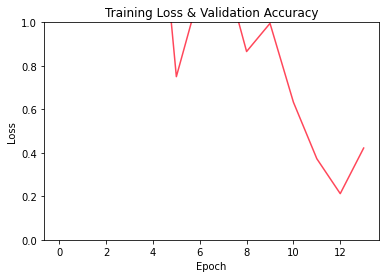

In [34]:
plot_loss_with_acc(loss_history)

## 4. Evaluation

### 4.1 preparation

In [53]:
from utils import printer

In [54]:
### 定义评价需要用的变量
parser_test = argparse.ArgumentParser()

parser_test.add_argument('--model', help = 'neural models to encode sentences', type = str, default = 'WATT')
parser_test.add_argument('--use_baseline',  help ='baseline or hier', type = bool, default = False)
parser_test.add_argument('--mode',  help= 'test mode', type = str, default = 'pr')
parser_test.add_argument('--gpu',  help =  'gpu(s) to use', type = str, default = '2')
parser_test.add_argument('--allow_growth',  help =  'occupying gpu(s) gradually', type = bool, default = True)
parser_test.add_argument('--checkpoint_path', help='path to store model', type = str, default = './outputs/ckpt/')
parser_test.add_argument('--logits_path', help = 'path to store model', type = str, default = './outputs/logits/')
parser_test.add_argument('--data_path',  help = 'path to load data', type = str, default = './data/')
parser_test.add_argument('--batch_size', help ='instance(entity pair) numbers to use each training(testing) time', type = int, default = 262)

# training settings
parser_test.add_argument('--max_epoch',  help = 'maximum of training epochs', type = int, default = 30)
parser_test.add_argument('--save_epoch',  help = 'frequency of training epochs', type = int, default = 40)
parser_test.add_argument('--learning_rate', help = 'entity numbers used each training time', type = float, default = 0.2)
parser_test.add_argument('--weight_decay', help = 'weight_decay', type = float, default = 0.00001)
parser_test.add_argument('--keep_prob', help = 'dropout rate', type = float, default = 1.0)

# test_settings
parser_test.add_argument('--test_single', help =  'only test one checkpoint', type = bool, default = True)
parser_test.add_argument('--test_start_ckpt', help = 'first epoch to test', type = int, default = 1)
parser_test.add_argument('--test_end_ckpt', help = 'last epoch to test', type = int, default = 30)
parser_test.add_argument('--test_sleep', help = 'time units to sleep ', type = float, default = 10)
parser_test.add_argument('--test_use_step', help = 'test step instead of epoch', type = bool, default = False)
parser_test.add_argument('--test_start_step', help = 'first step to test', type = int, default = 0*1832)
parser_test.add_argument('--test_end_step', help = 'last step to test', type = int, default = 30*1832)
parser_test.add_argument('--test_step', help = 'step to add per test', type = int , default = 1832)

# parameters
parser_test.add_argument('--word_size',  help = 'maximum of relations', type = int, default = config['word_size'])
parser_test.add_argument('--hidden_size',help = 'hidden feature size', type = int, default = 230)
parser_test.add_argument('--pos_size', help = 'position embedding size', type = int, default = 5)

# statistics
parser_test.add_argument('--max_length', help = 'maximum of number of words in one sentence', type = int, default = config['fixlen'])
parser_test.add_argument('--pos_num', help = 'number of position embedding vectors', type = int, default = config['maxlen'])
parser_test.add_argument('--num_classes', help = 'maximum of relations', type = int, default = len(config['relation2id']))
parser_test.add_argument('--vocabulary_size', help= 'maximum of relations', type = int, default = len(config['word2id']))

args_test = parser_test.parse_args(args = [])

In [55]:
import sys

class MyPrinter(object):
    def __init__(self, ):
        super(Printer, self).__init__()
        self._maxlen = 0

    def __call__(self, x, inplace=True):       
        if inplace:
            if len(x) >= self._maxlen:
                self._maxlen = len(x)
            else:
                x = x + ' ' * (self._maxlen - len(x))
            sys.stdout.write(x + '\r')
            sys.stdout.flush()
        else:
            self._maxlen = 0
            print(x)
        return self._maxlen

    @property
    def maxlen(self):
        return self._maxlen

    @maxlen.setter
    def maxlen(self, val):
        self._maxlen = val
        return val

In [56]:
mode = "hit_k_100" #在这里更改评价模式：可选 hit_k_100, hit_k_200, pr, pone, ptwo, pall
export_path = args_test.data_path # 在这里更改输出logits的目录 
pter = printer.Printer()

if mode == 'hit_k_100' or mode == 'hit_k_200':
    f = open("raw_data/relation2id.txt", "r")
    content = f.readlines()[1:]
    id2rel = {}
    for i in content:
        rel, rid = i.strip().split()
        id2rel[(int)(rid)] = rel
    f.close()

    fewrel = {}
    if mode == 'hit_k_100': # 选择读取文件
        f = open("data/rel100.txt", "r")
    else:
        f = open("data/rel200.txt", "r")
    content = f.readlines()
    for i in content:
        fewrel[i.strip()] = 1
    f.close()

In [57]:
if mode == 'pr' or mode == 'hit_k_100' or mode == 'hit_k_200':
    test_instance_triple = np.load(export_path + 'test_entity_pair.npy')
    test_instance_scope = np.load(export_path + 'test_entity_scope.npy')
    test_len = np.load(export_path + 'test_len.npy')
    test_label = np.load(export_path + 'test_label.npy')
    test_word = np.load(export_path + 'test_word.npy')
    test_pos1 = np.load(export_path + 'test_pos1.npy')
    test_pos2 = np.load(export_path + 'test_pos2.npy')
    test_mask = np.load(export_path + 'test_mask.npy')
    exclude_na_flatten_label = np.load(export_path + 'all_true_label.npy')
    
    test_instance_scope_Tensor = torch.LongTensor(test_instance_scope).to(DEVICE)
    test_len_Tensor = torch.LongTensor(test_len).to(DEVICE)
    test_label_Tensor = torch.LongTensor(test_label).to(DEVICE)
    test_word_Tensor = torch.LongTensor(test_word).to(DEVICE)
    test_pos1_Tensor = torch.LongTensor(test_pos1).to(DEVICE)
    test_pos2_Tensor = torch.LongTensor(test_pos2).to(DEVICE)
    test_mask_Tensor = torch.LongTensor(test_mask).to(DEVICE)
    exclude_na_flatten_label_Tensor = torch.LongTensor(exclude_na_flatten_label).to(DEVICE)
else:
    test_instance_triple = np.load(export_path + 'pn/test_entity_pair_pn.npy')
    test_instance_scope = np.load(export_path + 'pn/test_entity_scope_'+mode+'.npy')
    test_len = np.load(export_path + 'pn/test_len_'+mode+'.npy')
    test_label = np.load(export_path + 'pn/test_label_'+mode+'.npy')
    test_word = np.load(export_path + 'pn/test_word_'+mode+'.npy')
    test_pos1 = np.load(export_path + 'pn/test_pos1_'+mode+'.npy')
    test_pos2 = np.load(export_path + 'pn/test_pos2_'+mode+'.npy')
    test_mask = np.load(export_path + 'pn/test_mask_'+mode+'.npy')
    exclude_na_flatten_label = np.load(export_path + 'pn/true_label.npy')
    
    test_instance_scope_Tensor = torch.LongTensor(test_instance_scope).to(DEVICE)
    test_len_Tensor = torch.LongTensor(test_len).to(DEVICE)
    test_label_Tensor = torch.LongTensor(test_label).to(DEVICE)
    test_word_Tensor = torch.LongTensor(test_word).to(DEVICE)
    test_pos1_Tensor = torch.LongTensor(test_pos1).to(DEVICE)
    test_pos2_Tensor = torch.LongTensor(test_pos2).to(DEVICE)
    test_mask_Tensor = torch.LongTensor(test_mask).to(DEVICE)
    exclude_na_flatten_label_Tensor = torch.LongTensor(exclude_na_flatten_label).to(DEVICE)

In [58]:
exclude_na_label = np.reshape(exclude_na_flatten_label, [-1, args_test.num_classes-1]) #在这里我们要排除NA标签, 实际上这个文件 all_true_label 就是非出去了第一列NA关系的文件
index_non_zero = np.sum(exclude_na_label, 0) > 0  #如果这个标签>0 ，那么就代表这一行不是NA
exclude_na_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
exclude_na_label_Tensor = torch.reshape(exclude_na_flatten_label_Tensor, [-1, args_test.num_classes-1]) #在这里我们要排除NA标签, 实际上这个文件 all_true_label 就是非出去了第一列NA关系的文件
index_non_zero_Tensor = torch.LongTensor(index_non_zero).to(DEVICE) #如果这个标签>0 ，那么就代表这一行不是NA
index_non_zero_Tensor

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0], device='cuda:0')

In [50]:
print('reading test data finished')
print('entity pairs     : %d' % (len(test_instance_triple)))
print('sentences        : %d' % (len(test_len)))
print('relations        : %d' % (args_test.num_classes))
print('word size        : %d' % (args_test.word_size))
print('position size    : %d' % (args_test.pos_size))
print('hidden size      : %d' % (args_test.hidden_size))

reading test data finished
entity pairs     : 96678
sentences        : 172448
relations        : 53
word size        : 50
position size    : 5
hidden size      : 230


### 4.2 Evaluation

In [60]:
start_ckpt = args_test.test_start_ckpt #first epoch to test
start_step = args_test.test_start_step #first step to test
if args.test_single: # only test one checkpoint
    end_ckpt = args_test.test_start_ckpt
    end_step = args_test.test_start_step
else:
    end_ckpt = args_test.test_end_ckpt # last epoch to test
    end_step = argargs_tests.test_end_step # last step to test

if args.test_use_step == False: # test step instead of epoch
    iteration_list = range(start_ckpt, end_ckpt+1)
else:
    iteration_list = range(start_step, end_step+1, args_test.test_step)

In [62]:
if args_test.use_baseline:
    model = HAttentionNetwork(sentence_encoder, relation_levels_Tensor, relation_level_layer,  0.8, 230, args.batch_size, test_batch_size= args_test.batch_size).to(DEVICE)
else:
    model = HAttentionNetwork(sentence_encoder, relation_levels_Tensor, relation_level_layer,  0.8, 230, args.batch_size, test_batch_size= args_test.batch_size).to(DEVICE)
    
print('building finished...')

building finished...


<ipython-input-27-e14f31155eab>:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.relation_matrixs.append(nn.Embedding(self.layer[i], self.hidden_size, _weight = nn.init.xavier_uniform(torch.Tensor(self.layer[i], self.hidden_size))).to(DEVICE))
<ipython-input-27-e14f31155eab>:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.discrimitive_matrix)


### 5.2 评价主要过程（需要重写)

In [63]:
mode = "pr"

In [64]:
model.load_state_dict(torch.load(args_test.checkpoint_path + args_test.model+"_params-iter-"+str(args_test.save_epoch*1832*iters)+'.pkl'))

NameError: name 'iters' is not defined

In [319]:
for iters in range(start_ckpt, end_ckpt+1):

    if args_test.test_use_step == False:
        pter('waiting for epoch' + str(args_test.save_epoch*iters)+'...')
        while args_test.model+"_params-iter-"+str(args_test.save_epoch*1832*iters)+'.pkl' not in os.listdir(args_test.checkpoint_path):
            time.sleep(args_test.test_sleep)
            model.load_state_dict(torch.load(args_test.checkpoint_path+  args_test.model+"_params-iter-"+str(args_test.save_epoch*1832*iters)+'.pkl'))
    else:
        pter('waiting for step' + str(iters)+'...')
        while args_test.model+"-"+str(iters)+'.index' not in os.listdir(args_test.checkpoint_path):
            time.sleep(args_test.test_sleep)
            model.load_state_dict(torch.load(args_test.checkpoint_path+args_test.model+"_params-iter-"+str(iters)+'.pkl'))
    model.eval()
    with torch.no_grad():
        
        stack_output = []  # stack_out 干什么的

        iteration = len(test_instance_scope) // args_test.batch_size
        for i in range(iteration): #循环迭代次数
            if args_test.test_use_step == False:
                pter('running '+str(i)+'/'+str(iteration)+' for epoch ' + str(args_test.save_epoch*iters) + '...')
            else:
                pter('running '+str(i)+'/'+str(iteration)+' for step ' + str(iters) + '...')
            input_scope = test_instance_scope[i * args_test.batch_size:(i+1)*args_test.batch_size]
            index = []
            scope = [0]
            label = []
            for num in input_scope:
                index = index + list(range(num[0], num[1] + 1))
                label.append(test_label[num[0]])
                scope.append(scope[len(scope)-1] + num[1] - num[0] + 1)
            label_ = np.zeros((args_test.batch_size, args_test.num_classes))
            label_[np.arange(args_test.batch_size), label] = 1

            feed_dict = {
                'word': test_word_Tensor[index, :],
                'pos1': test_pos1_Tensor[index, :],
                'pos2': test_pos2_Tensor[index, :],
                'mask': test_mask_Tensor[index, :],
                'len': test_len_Tensor[index],
                'label_': label_,  # 可以不用
                'scope': scope
            }


            output = model.forward_infer(feed_dict).cpu().numpy()

            stack_output.append(output) # 将输出，拼接到输出stack里边

        if args_test.test_use_step == False: 
            pter('evaluating epoch ' + str(args_test.save_epoch*iters) + '...')
        else:
            pter('evaluating step ' + str(iters) + '...')

        stack_output = np.concatenate(stack_output, axis=0) # 拼接输出
        exclude_na_output = stack_output[:,1:]  # 拼接从排除NA列的输出
        exclude_na_flatten_output = np.reshape(stack_output[:,1:],(-1))  #重置stack_output的维度

        if mode == 'hit_k_100' or mode == 'hit_k_200':
            ss = 0
            ss10 = 0
            ss15 = 0
            ss20 = 0

            ss_rel = {}
            ss10_rel = {}
            ss15_rel = {}
            ss20_rel = {}

            for j, label in zip(exclude_na_output, exclude_na_label):
                score = None
                num = None
                for ind, ll in enumerate(label):
                    if ll > 0:
                        score = j[ind]
                        num = ind
                        break
                if num is None:
                    continue
                if id2rel[num+1] in fewrel:
                    ss += 1.0
                    mx = 0
                    for sc in j:
                        if sc > score:
                            mx = mx + 1
                    if not num in ss_rel:
                        ss_rel[num] = 0
                        ss10_rel[num] = 0
                        ss15_rel[num] = 0
                        ss20_rel[num] = 0
                    ss_rel[num] += 1.0
                    if mx < 10:
                        ss10+=1.0
                        ss10_rel[num] += 1.0
                    if mx < 15:
                        ss15+=1.0
                        ss15_rel[num] += 1.0
                    if mx < 20:
                        ss20+=1.0
                        ss20_rel[num] += 1.0
            print ("mi")
            print (ss10/ss)
            print (ss15/ss)
            print (ss20/ss)
            print ("ma")
            print ((np.array([ss10_rel[i]/ss_rel[i]  for i in ss_rel])).mean())
            print ((np.array([ss15_rel[i]/ss_rel[i]  for i in ss_rel])).mean())
            print ((np.array([ss20_rel[i]/ss_rel[i]  for i in ss_rel])).mean())

        elif mode == 'pr':
            m = average_precision_score(exclude_na_flatten_label, exclude_na_flatten_output)
            M = average_precision_score(exclude_na_label[:,index_non_zero], exclude_na_output[:,index_non_zero], average='macro')
            np.save(args_test.logits_path+"WATT"+str(iters), exclude_na_flatten_output)
            print(m, M)
        else:
            order = np.argsort(-exclude_na_flatten_output)            
            print(np.mean(exclude_na_flatten_label[order[:100]]))
            print(np.mean(exclude_na_flatten_label[order[:200]]))
            print(np.mean(exclude_na_flatten_label[order[:300]]))

<ipython-input-249-4b0cdd8ea961>:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  current_score = torch.cat([F.softmax(current_logit[:, data['scope'][j]:data['scope'][j + 1]]) for j in range(self.test_batch_size)], 1)
<ipython-input-249-4b0cdd8ea961>:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  test_output = torch.diagonal(F.softmax(test_logits))


0.2682507572531968 0.09754817803075651


In [320]:
args_test.logits_path

'./outputs/logits/'

In [321]:
iters

1

## 6. 绘制图形

### 6.1 绘制P-R图

#### HNRE-CNN图

AUC: 0.2683


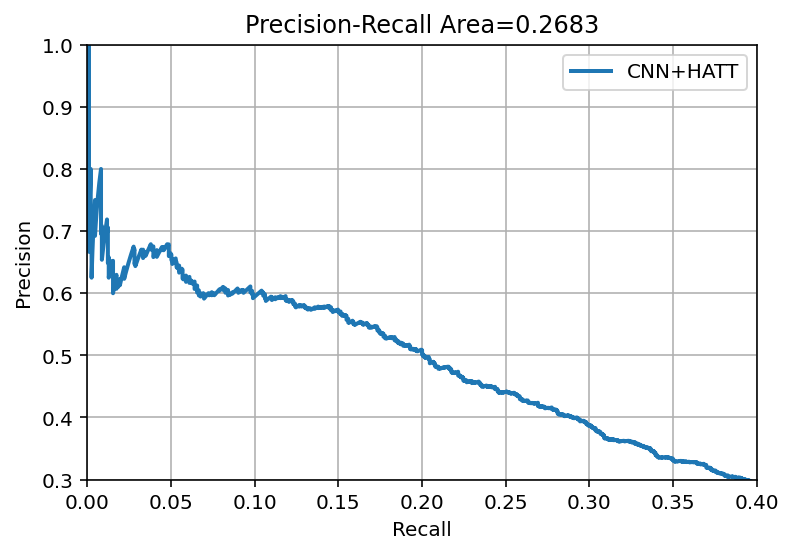

In [322]:

label = './data/all_true_label.npy'
# score = sys.argv[1]
score = args_test.logits_path+"WATT1.npy" # 
y_true = np.load(label)
y_scores = np.load(score)


auc = average_precision_score(y_true, y_scores)
print('AUC: {0:1.4f}'.format(auc))

precision,recall,threshold = precision_recall_curve(y_true,y_scores)

plt.plot(recall[:], precision[:], lw=2, label="CNN+HATT")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.3, 1.0])
plt.xlim([0.0, 0.4])
plt.title('Precision-Recall Area={0:1.4f}'.format(auc))
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


<ipython-input-6-06c843c6b72d>:97: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig('fig.eps', format='eps',dpi=2000, bbox_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\Johan\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


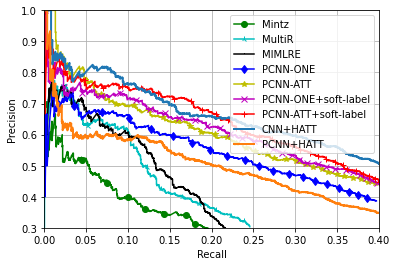

In [6]:
hh = open("./plot/Hoffmann.txt", "r")
mi = open("./plot/Mintz.txt", "r")
ml = open("./plot/MIMLRE.txt", "r")
g = open("./plot/lykATT.txt", "r")
h = open("./plot/lykONE.txt", "r")
o = open("./plot/att+soft-label.txt", "r")
tt = open("./plot/one+soft-label.txt", "r")

xx = []
yy = []
x1 = []
y1 = []
x2 = []
y2 = []
x3 = []
y3 = []

x4, y4 = [], []
x5, y5 = [], []
x6, y6 = [], []
for line in hh:
    line = line.strip()
    it = line.split()
    x4.append(float(it[0]))
    y4.append(float(it[1]))
for line in mi:
    line = line.strip()
    it = line.split()
    x5.append(float(it[0]))
    y5.append(float(it[1]))
for line in ml:
    line = line.strip()
    it = line.split()
    x6.append(float(it[0]))
    y6.append(float(it[1]))


for line in g:
    line = line.strip()
    it = line.split()
    xx.append(float(it[0]))
    yy.append(float(it[1]))

for line in h:
    line = line.strip()
    it = line.split()
    x1.append(float(it[0]))
    y1.append(float(it[1]))

for line in o:
    line = line.strip()
    it = line.split()
    x2.append(float(it[0]))
    y2.append(float(it[1]))

for line in tt:
    line = line.strip()
    it = line.split()
    x3.append(float(it[0]))
    y3.append(float(it[1]))
plt.ylim(0.3,1.0)
plt.xlim(0,0.4)
# plot(y, x, "r")
# plt.show()

plot(x5, y5, "-g", marker="o", markevery=160,label="Mintz")
plot(x4, y4, "-c", marker="2", markevery=160,label="MultiR")
plot(x6, y6, "-k", marker=",", markevery=160,label="MIMLRE")
plot(y1, x1, "-b", marker="d", markevery=100,label="PCNN-ONE")
plot(yy, xx, "y", marker="*", markevery=60, label="PCNN-ATT")
plot(y3, x3, "m", marker="x", markevery=60,label="PCNN-ONE+soft-label")
plot(y2, x2, "r", marker="+", markevery=60,label="PCNN-ATT+soft-label")


label = './data/all_true_label.npy'

score = args_test.logits_path+"cnn_hier10.npy" # 
y_true = np.load(label)
y_scores = np.load(score)
auc = average_precision_score(y_true, y_scores)
precision,recall,threshold = precision_recall_curve(y_true,y_scores)

plt.plot(recall[:], precision[:], lw=2, label="CNN+HATT")

score = args_test.logits_path+"pcnn_hier1.npy" # 
y_true = np.load(label)
y_scores = np.load(score)
auc = average_precision_score(y_true, y_scores)
precision,recall,threshold = precision_recall_curve(y_true,y_scores)

plt.plot(recall[:], precision[:], lw=2, label="PCNN+HATT")

ylabel('Precision')
xlabel('Recall')
legend()
grid()
savefig('fig.eps', format='eps',dpi=2000, bbox_inches='tight')
show()